### Imports

In [1]:
import pandas as pd
import numpy as np
import json

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

### Load Dataframes

In [2]:
df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv', index_col=[0,1])
df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv', index_col=[0,1])
df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv', index_col=[0,1])

# df_1km = pd.read_csv('Datasets/Machine Learning/Dataframes/1km_All_Birds_DF.csv')
# df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv')
# df_10km = pd.read_csv('Datasets/Machine Learning/Dataframes/10km_All_Birds_DF.csv')

df_dicts = [
    {'name' : '1km', 'dataframe' : df_1km},
    {'name' : '5km', 'dataframe' : df_5km},
    {'name' : '10km', 'dataframe' : df_10km}
]

### Data Cleaning

In [3]:
# Drop random rows with Occurence=0 to even out the datasets
for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index
    sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


1km data before drop: 
 Occurrence
0    876916
1     33084
dtype: int64 

1km data after drop: 
 Occurrence
0    33084
1    33084
dtype: int64 

5km data before drop: 
 Occurrence
0    28435
1     7965
dtype: int64 

5km data after drop: 
 Occurrence
0    7965
1    7965
dtype: int64 

10km data before drop: 
 Occurrence
0    6428
1    2672
dtype: int64 

10km data after drop: 
 Occurrence
0    2672
1    2672
dtype: int64 



### Standardisation

In [4]:
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

### Feature Selection

In [5]:
# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
    kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])

    print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

## Pipeline for all three cell sizes
This section is the main pipeline that will be used for evaluation

In [14]:
seed = 42
verbose = False

estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(X, y)

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test


    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    stack_clf.fit(X_train, y_train)
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred)
    
    print(f'Classification report: \n {dict["report"]} \n')



Training with 1km cells... 

K-Best Features Dataframe: 
         F Score        P Value                      Attribute
23  77851.670197   0.000000e+00                   Surface type
30  75884.875585   0.000000e+00                     Glyphosate
34  75884.875585   0.000000e+00                  Pendimethalin
29  75870.653583   0.000000e+00                 Chlorothalonil
31  75856.435412   0.000000e+00                       Mancozeb
32  75842.221071   0.000000e+00                     Mecoprop-P
25  68174.029650   0.000000e+00   Inflowing drainage direction
21  60860.968184   0.000000e+00                      Elevation
24  48784.337390   0.000000e+00  Outflowing drainage direction
26  36745.920764   0.000000e+00                   Fertiliser K
27  36745.920764   0.000000e+00                   Fertiliser N
28  36745.920764   0.000000e+00                   Fertiliser P
37  30593.258835   0.000000e+00                        Sulphur
36  30450.409212   0.000000e+00                   Prosulfocar

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      8295
           1       0.83      0.94      0.88      8247

    accuracy                           0.87     16542
   macro avg       0.88      0.87      0.87     16542
weighted avg       0.88      0.87      0.87     16542
 

Training with 5km cells... 

K-Best Features Dataframe: 
         F Score        P Value                      Attribute
21  28413.557624   0.000000e+00                      Elevation
23  27569.138544   0.000000e+00                   Surface type
25  24860.171069   0.000000e+00   Inflowing drainage direction
26   9260.901910   0.000000e+00                   Fertiliser K
27   9260.901910   0.000000e+00                   Fertiliser N
28   9260.901910   0.000000e+00                   Fertiliser P
29   5931.696748   0.000000e+00             Chlorothalonil_5km
30   5931.696748   0.000000e+00                 Glyphosate_5km
31   5931.696748   0.0

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1981
           1       0.89      0.95      0.92      2002

    accuracy                           0.91      3983
   macro avg       0.91      0.91      0.91      3983
weighted avg       0.91      0.91      0.91      3983
 

Training with 10km cells... 

K-Best Features Dataframe: 
         F Score        P Value                      Attribute
21  13546.074684   0.000000e+00                      Elevation
25  12049.852921   0.000000e+00   Inflowing drainage direction
23  10529.998189   0.000000e+00                   Surface type
26   2226.785286   0.000000e+00                   Fertiliser K
27   2226.785286   0.000000e+00                   Fertiliser N
28   2226.785286   0.000000e+00                   Fertiliser P
29   2030.024219   0.000000e+00            Chlorothalonil_10km
30   2030.024219   0.000000e+00                Glyphosate_10km
34   2030.024219   0.

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       687
           1       0.95      0.93      0.94       649

    accuracy                           0.94      1336
   macro avg       0.94      0.94      0.94      1336
weighted avg       0.94      0.94      0.94      1336
 



In [15]:
for dict in df_dicts:
    print(dict["y_test"])
    print(dict["predictions"].shape)

    # dict["predictions"] = dict["y"].insert(len(dict["y"].columns), 'Predictions', dict["predictions"])
    print(f'{dict["predictions"]}')

                    Occurrence
y         x                   
571500.0  691500.0           0
685500.0  312500.0           1
596500.0  522500.0           0
51500.0   257500.0           1
868500.0  477500.0           0
...                        ...
892500.0  254500.0           1
244500.0  227500.0           1
1039500.0 28500.0            0
376500.0  444500.0           1
586500.0  81500.0            1

[16542 rows x 1 columns]
(16542,)
[0 1 0 ... 0 1 0]
                    Occurrence
y         x                   
652500.0  232500.0           1
262500.0  552500.0           1
1092500.0 42500.0            0
462500.0  697500.0           0
392500.0  517500.0           0
...                        ...
472500.0  462500.0           1
512500.0  442500.0           1
1147500.0 62500.0            0
102500.0  482500.0           1
402500.0  127500.0           0

[3983 rows x 1 columns]
(3983,)
[1 1 0 ... 0 1 0]
                    Occurrence
y         x                   
315000.0  305000.0          

: 

In [31]:
# Show features
# for dict in df_dicts:
#     print(f"{dict['name']} dataset feature dictionary: {json.dumps(dict['kbest']['10'], indent=4)}")

1km dataset feature dictionary: [
    "Elevation",
    "Surface type",
    "Outflowing drainage direction",
    "Inflowing drainage direction",
    "Fertiliser P",
    "Chlorothalonil",
    "Glyphosate",
    "Mancozeb",
    "Mecoprop-P",
    "Pendimethalin"
]
5km dataset feature dictionary: [
    "Improve grassland",
    "Elevation",
    "Surface type",
    "Inflowing drainage direction",
    "Fertiliser K",
    "Fertiliser N",
    "Fertiliser P",
    "Mancozeb_5km",
    "Mecoprop-P_5km",
    "Pendimethalin_5km"
]
10km dataset feature dictionary: [
    "Elevation",
    "Surface type",
    "Inflowing drainage direction",
    "Fertiliser K",
    "Fertiliser N",
    "Fertiliser P",
    "Chlorothalonil_10km",
    "Glyphosate_10km",
    "Mecoprop-P_10km",
    "Pendimethalin_10km"
]


## Individual model testing
This section is for testing the effectiveness of individual models with different machine learning algorithms and methods 

### Train-Test Split

In [ ]:
# Train test split (change this since I made the coordinates the index)
coords, X, y = df_5km.iloc[:, :2], df_5km.iloc[:, 2:-1], df_5km.iloc[:, [-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=42)

### Individual models

In [ ]:
# Logistic regression
logreg_clf= LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l1', n_jobs=2).fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(logreg_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(logreg_clf.score(X_test, y_test)))
# f1_score(y_test, logreg_clf.predict(X_test))

y_pred = logreg_clf.predict(X_test)
# print(len(y_pred)==len(y_test))
print(classification_report(y_test, y_pred))

Accuracy score (training): 0.892
Accuracy score (testing): 0.889
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7084
           1       0.89      0.57      0.70      2016

    accuracy                           0.89      9100
   macro avg       0.89      0.78      0.81      9100
weighted avg       0.89      0.89      0.88      9100



In [ ]:
# K Nearest Neigbours
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance').fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(knn_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(knn_clf.score(X_test, y_test)))
# f1_score(y_test, knn_clf.predict(X_test))

print(classification_report(y_test, knn_clf.predict(X_test)))

Accuracy score (training): 0.996
Accuracy score (testing): 0.651
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      6411
           1       0.65      0.66      0.65      6387

    accuracy                           0.65     12798
   macro avg       0.65      0.65      0.65     12798
weighted avg       0.65      0.65      0.65     12798



In [ ]:
sgd_clf = SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')
sgd_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(sgd_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(sgd_clf.score(X_test, y_test)))
# f1_score(y_test, clf1.predict(X_test))
print(classification_report(y_test, sgd_clf.predict(X_test)))

Accuracy score (training): 0.663
Accuracy score (testing): 0.658
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      6411
           1       0.63      0.75      0.69      6387

    accuracy                           0.66     12798
   macro avg       0.66      0.66      0.65     12798
weighted avg       0.66      0.66      0.65     12798



In [ ]:
rf_clf = RandomForestClassifier(n_estimators=20,max_features=None, random_state=42)
rf_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(rf_clf.score(X_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(rf_clf.score(X_test, y_test)))
# print("F1-score: {0:.3f}".format(f1_score(y_test, rf_clf.predict(X_test))))
print(classification_report(y_test, rf_clf.predict(X_test)))

Accuracy score (training): 0.994
Accuracy score (testing): 0.676
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      6411
           1       0.68      0.66      0.67      6387

    accuracy                           0.68     12798
   macro avg       0.68      0.68      0.68     12798
weighted avg       0.68      0.68      0.68     12798



In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

lr_list1 = [1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]

lr_list2 = [15, 20, 25, 30, 35, 40] # Not Worth

lr_list3 = np.arange(2.0, 2.15, 0.01)

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=None, max_depth=3, random_state=42)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (testing): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    print(classification_report(y_test, gb_clf.predict(X_test)), '\n')


Learning rate:  0.05
Accuracy score (training): 0.689
Accuracy score (testing): 0.681
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      6411
           1       0.65      0.77      0.71      6387

    accuracy                           0.68     12798
   macro avg       0.69      0.68      0.68     12798
weighted avg       0.69      0.68      0.68     12798
 

Learning rate:  0.075
Accuracy score (training): 0.697
Accuracy score (testing): 0.690
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      6411
           1       0.67      0.75      0.71      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 

Learning rate:  0.1
Accuracy score (training): 0.697
Accuracy score (testing): 0.694
              precision    recall  f1-score   support

           0       0.71      

### Ensemble Models

In [ ]:
# Ensemble learning
estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l2')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=42))
]

stack_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=42)
)

stack_clf.fit(X_train, y_train)
print(classification_report(y_test, stack_clf.predict(X_test)), '\n')



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The ma

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      6411
           1       0.68      0.70      0.69      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 



In [ ]:
estimators = [
    ('lr', LogisticRegression(max_iter=1000, solver='saga', random_state=42, penalty='l2')),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier(loss='modified_huber', max_iter=1000, random_state=42, penalty='l2')),
    ('rf', RandomForestClassifier(n_estimators=20, max_features=None, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=42))
]

vote_clf =  VotingClassifier(estimators)

vote_clf.fit(X_train, y_train)
print(classification_report(y_test, vote_clf.predict(X_test)), '\n')

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      6411
           1       0.68      0.73      0.70      6387

    accuracy                           0.69     12798
   macro avg       0.69      0.69      0.69     12798
weighted avg       0.69      0.69      0.69     12798
 



## Plot Graphs

array([[<AxesSubplot: title={'center': 'Deciduous woodland'}>,
        <AxesSubplot: title={'center': 'Coniferous woodland'}>,
        <AxesSubplot: title={'center': 'Arable'}>,
        <AxesSubplot: title={'center': 'Improve grassland'}>],
       [<AxesSubplot: title={'center': 'Neutral grassland'}>,
        <AxesSubplot: title={'center': 'Calcareous grassland'}>,
        <AxesSubplot: title={'center': 'Acid grassland'}>,
        <AxesSubplot: title={'center': 'Fen'}>],
       [<AxesSubplot: title={'center': 'Heather'}>,
        <AxesSubplot: title={'center': 'Heather grassland'}>,
        <AxesSubplot: title={'center': 'Bog'}>,
        <AxesSubplot: title={'center': 'Inland rock'}>],
       [<AxesSubplot: title={'center': 'Saltwater'}>,
        <AxesSubplot: title={'center': 'Freshwater'}>,
        <AxesSubplot: title={'center': 'Supralittoral rock'}>,
        <AxesSubplot: title={'center': 'Supralittoral sediment'}>],
       [<AxesSubplot: title={'center': 'Littoral rock'}>,
       

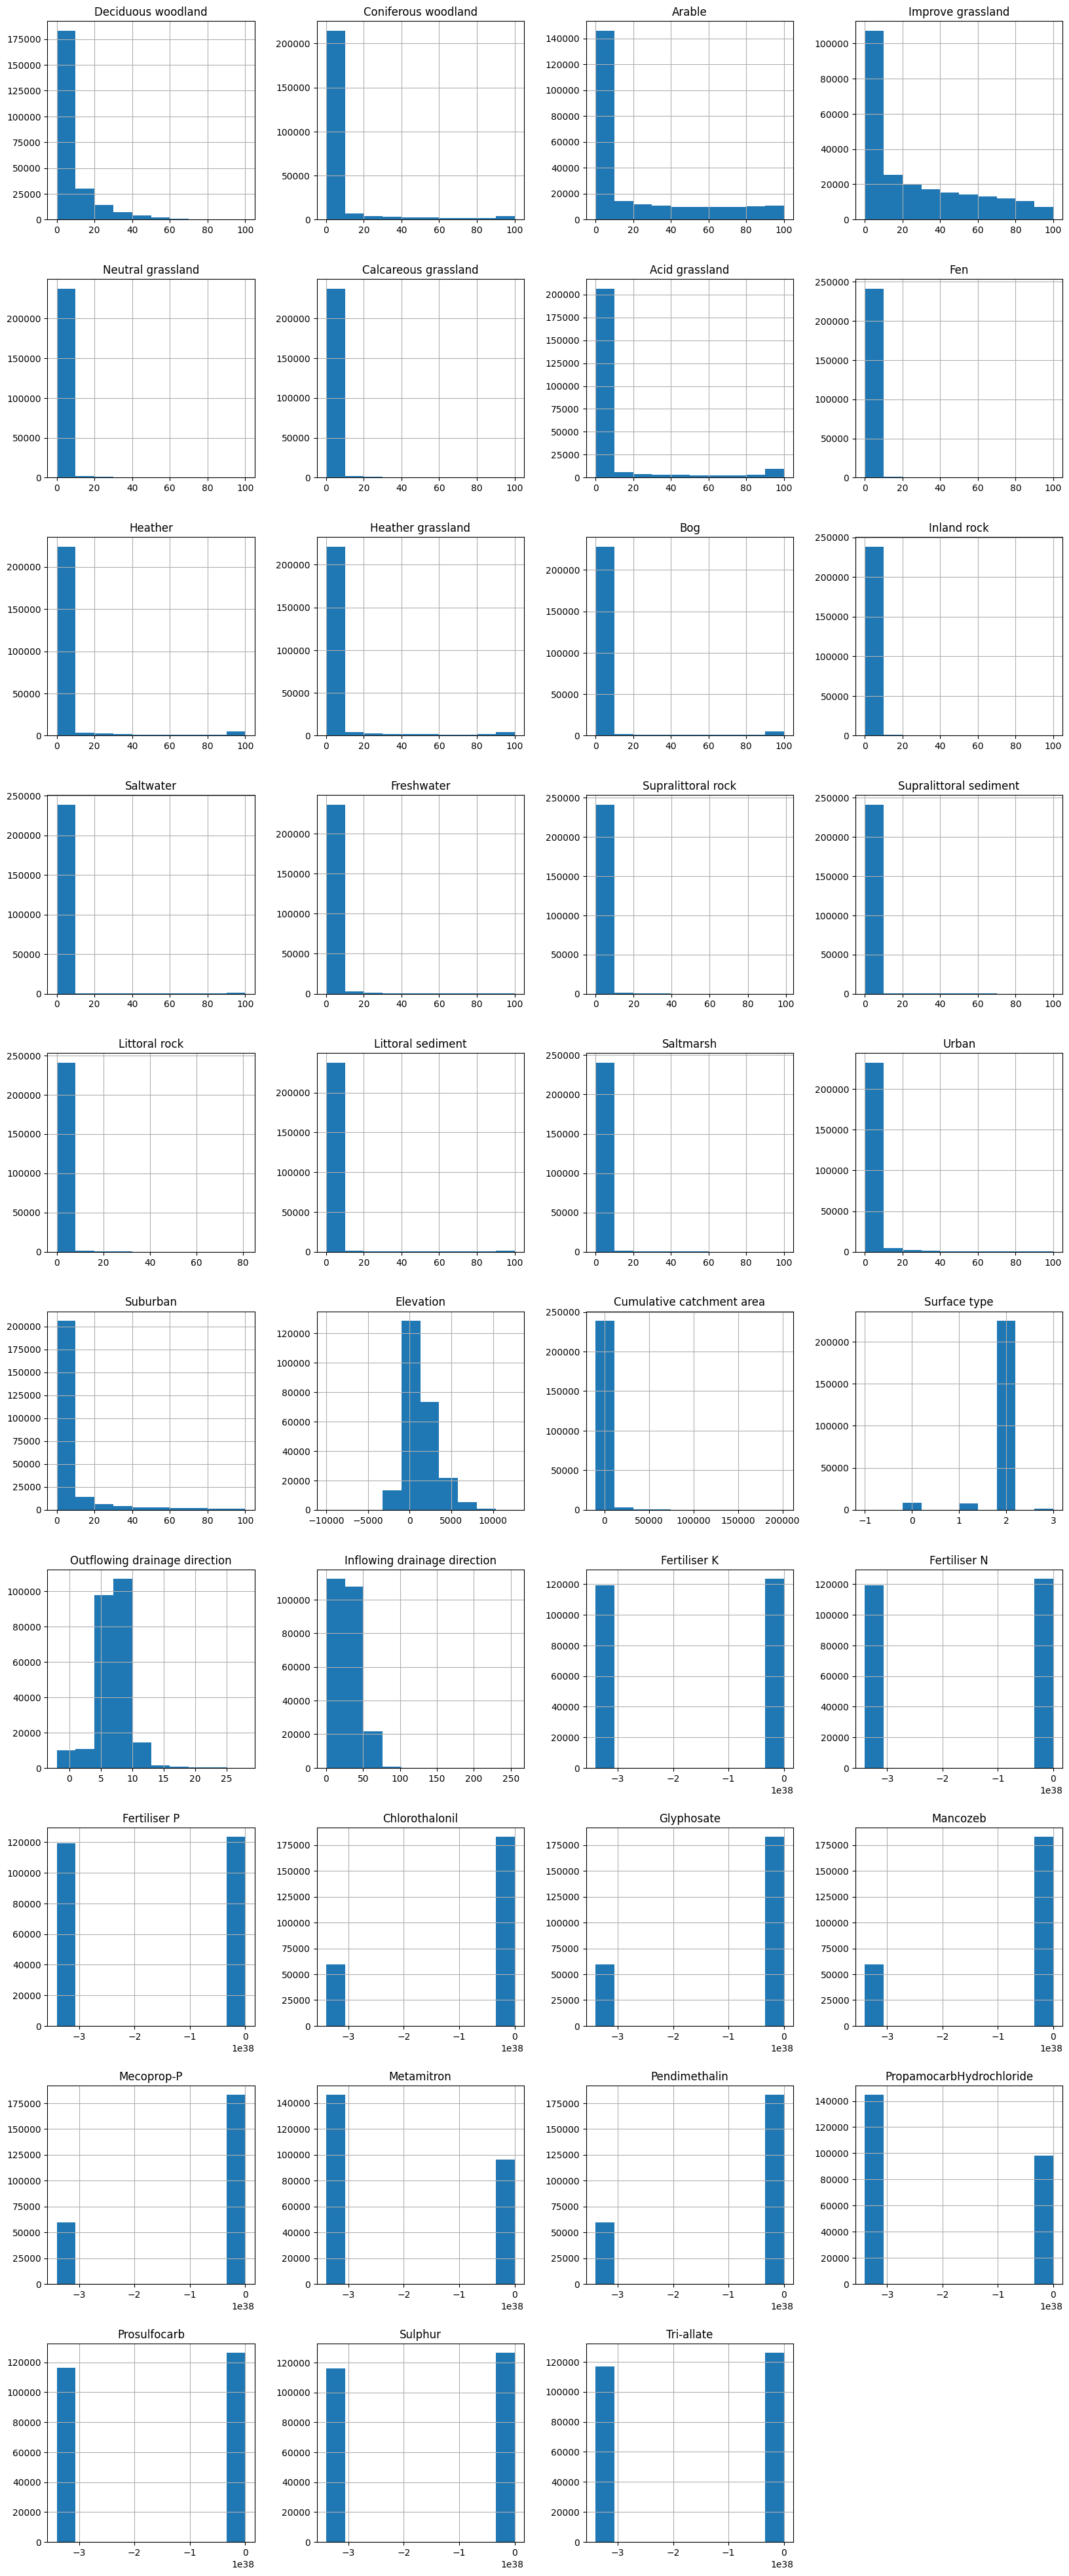

In [ ]:
# Plot distribution of colummns
%matplotlib inline
X.hist(figsize=(20, 50), layout=(10, 4))


array([[<AxesSubplot: title={'center': 'Deciduous woodland'}>,
        <AxesSubplot: title={'center': 'Coniferous woodland'}>,
        <AxesSubplot: title={'center': 'Arable'}>,
        <AxesSubplot: title={'center': 'Improve grassland'}>],
       [<AxesSubplot: title={'center': 'Neutral grassland'}>,
        <AxesSubplot: title={'center': 'Calcareous grassland'}>,
        <AxesSubplot: title={'center': 'Acid grassland'}>,
        <AxesSubplot: title={'center': 'Fen'}>],
       [<AxesSubplot: title={'center': 'Heather'}>,
        <AxesSubplot: title={'center': 'Heather grassland'}>,
        <AxesSubplot: title={'center': 'Bog'}>,
        <AxesSubplot: title={'center': 'Inland rock'}>],
       [<AxesSubplot: title={'center': 'Saltwater'}>,
        <AxesSubplot: title={'center': 'Freshwater'}>,
        <AxesSubplot: title={'center': 'Supralittoral rock'}>,
        <AxesSubplot: title={'center': 'Supralittoral sediment'}>],
       [<AxesSubplot: title={'center': 'Littoral rock'}>,
       

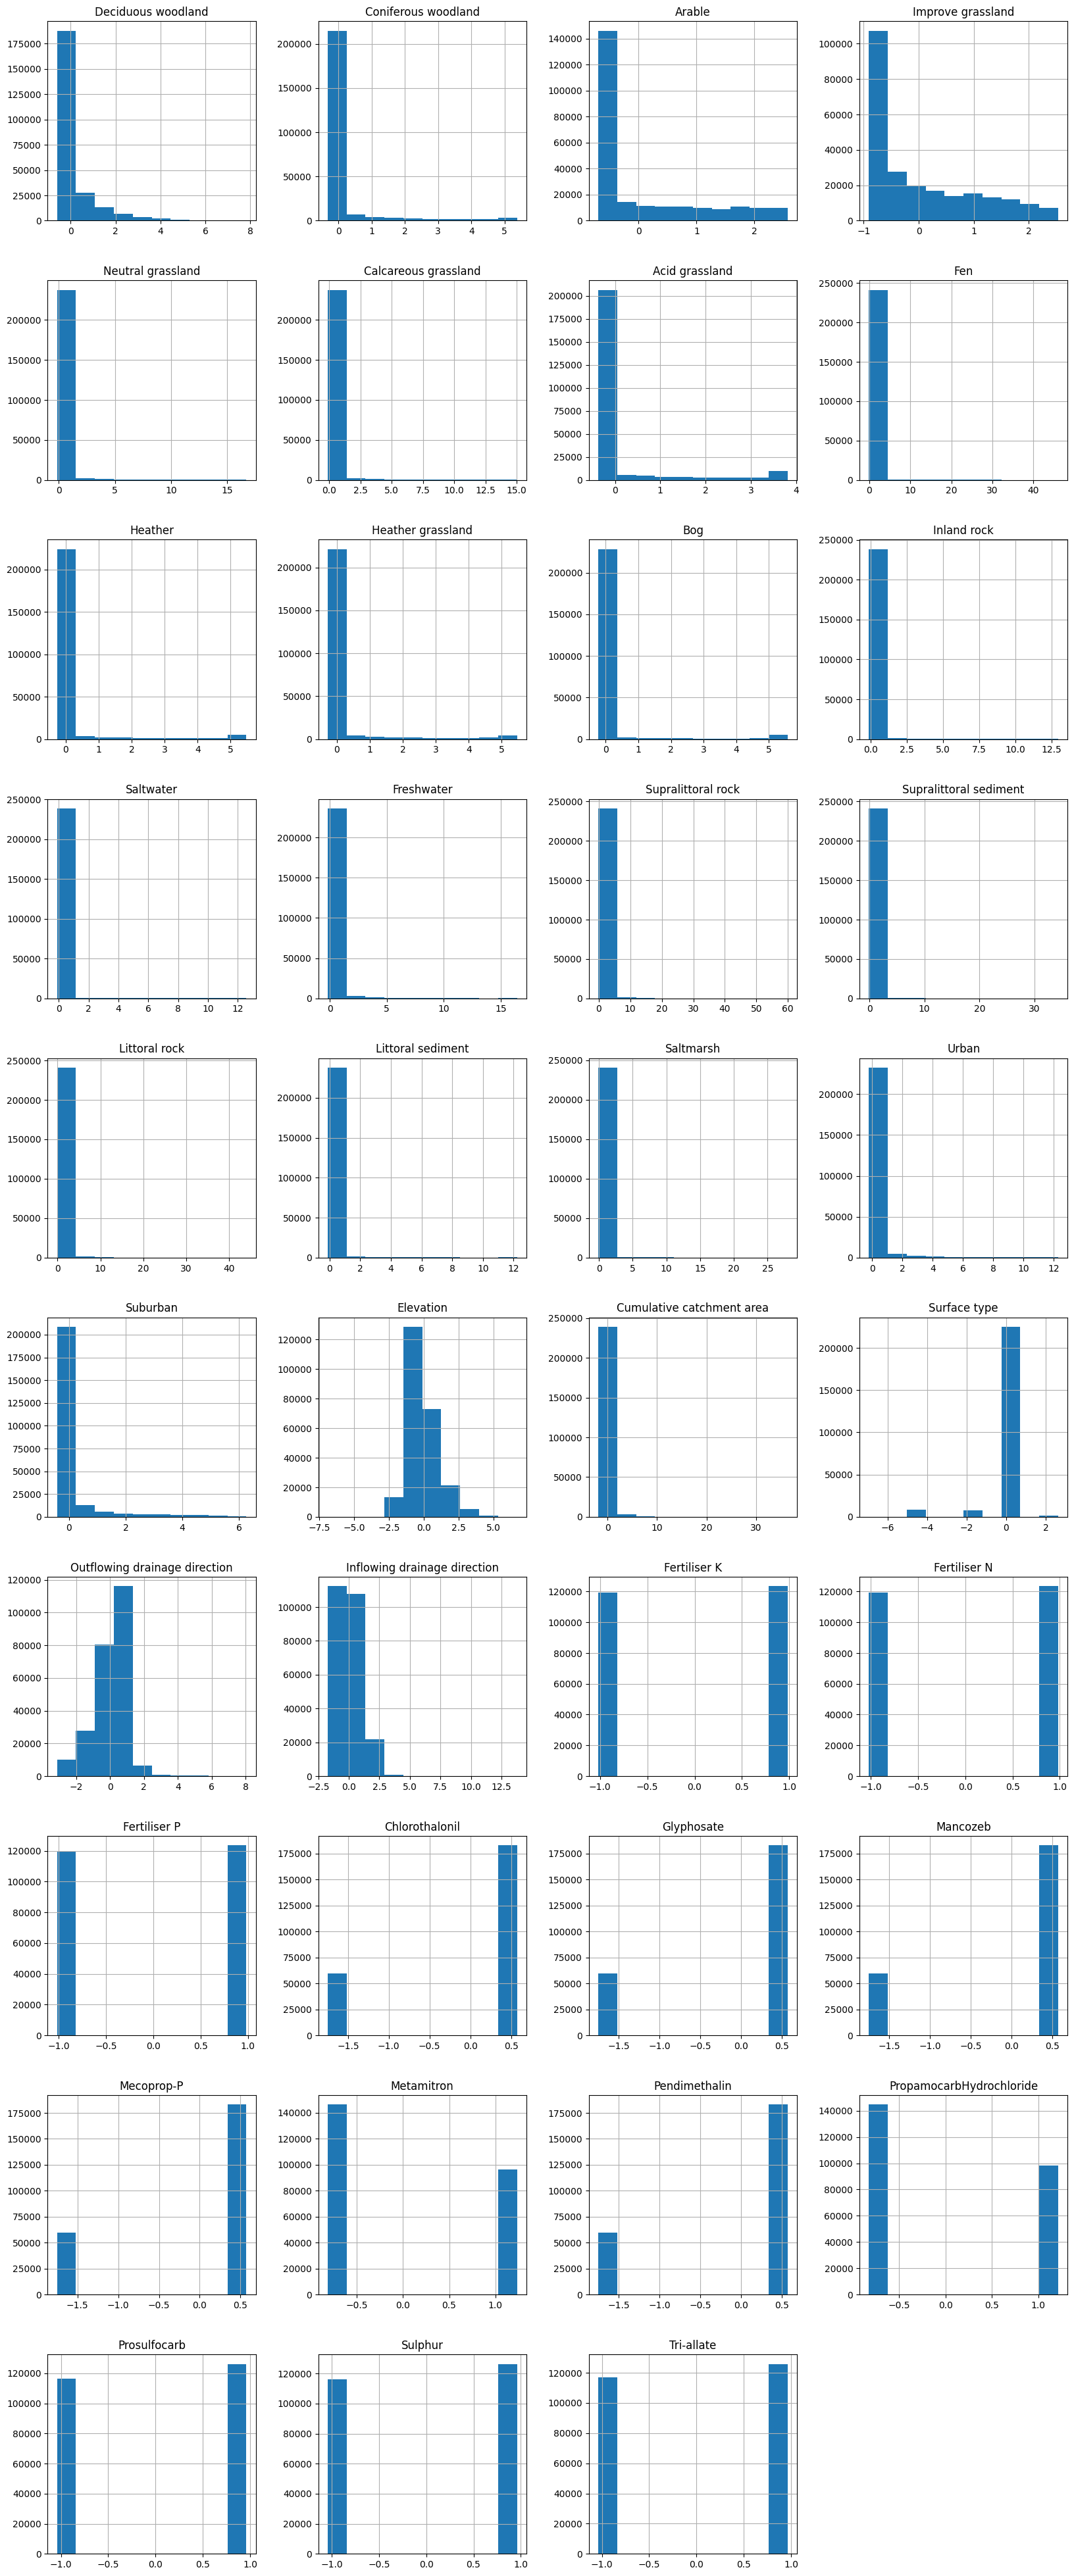

In [ ]:
X.hist(figsize=(20, 50), layout=(10, 4))